# 2. Regression

In [1]:
import sys
sys.path.append('../Utils')
from pre_processing import *

In [ ]:
import random
import scipy
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import scikitplot as skplt
import sklearn
from sklearn import preprocessing
from sklearn import datasets 
from sklearn.impute import SimpleImputer

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct,WhiteKernel,RBF,Matern,RationalQuadratic,ExpSineSquared,ConstantKernel,PairwiseKernel
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.decomposition import PCA
from sklearn.model_selection import *
from sklearn.metrics import *

## Plot MSE and R2

In [3]:
def plot_all(X_train, y_train, X_test, y_test, all_regrs, regr_names, file_name):
    plt.figure(figsize=(18,8))
    plt.suptitle("Dataset: %s"%file_name, size=16)
    ax1 = plt.subplot(121)
    mse_scores = plot_mse_score(X_train, y_train, X_test, y_test, all_regrs, regr_names, ax1)
    ax2 = plt.subplot(122)
    ax2.set_xlim(0,1)
    r2_scores = plot_r2_score(X_train, y_train, X_test, y_test, all_regrs, regr_names,ax2)
    plt.savefig(IMAGE_PATH+file.split('.')[0]+'_mse-r2')
    plt.show()
    return mse_scores,r2_scores

def plot_mse_score(X_train, y_train, X_test, y_test, all_regrs, regr_names, ax):
    mse_scores = dict()
    training_scores = []
    test_scores = []
    
    for regr, regr_name in zip(all_regrs, regr_names):
        train_preds = regr.predict(X_train)
        test_preds = regr.predict(X_test)
        train_score = sklearn.metrics.mean_squared_error(y_train, train_preds)
        test_score = sklearn.metrics.mean_squared_error(y_test, test_preds)
        training_scores.append(train_score)
        test_scores.append(test_score)
        mse_scores[regr_name] = test_score
        
    N = len(all_regrs)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    p1 = plt.barh(ind-width/2, training_scores, align='center', label='Training Set', height=width)
    p2 = plt.barh(ind+width/2, test_scores, align='center', label='Test Set', height=width)
    for i, v in enumerate(training_scores):
        plt.text(v,ind[i]-width/2.5,'%.3f'%v)
        plt.text(test_scores[i],ind[i]+width/1.5,'%.3f'%test_scores[i])
        
    plt.yticks(ind, regr_names) 
    plt.xlabel('MSE')
    plt.title('Mean Squared Error Of All Regressors')
    plt.legend(handles=[p1,p2])
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
#     ax.yaxis.tick_right()
    return mse_scores

def plot_r2_score(X_train, y_train, X_test, y_test, all_regrs, regr_names, ax):
    r2_scores = dict()
    training_scores = []
    test_scores = []
    
    for regr, regr_name in zip(all_regrs, regr_names):
        train_preds = regr.predict(X_train)
        test_preds = regr.predict(X_test)
        train_score = sklearn.metrics.r2_score(y_train, train_preds)
        test_score = sklearn.metrics.r2_score(y_test, test_preds)
        training_scores.append(train_score)
        test_scores.append(test_score)
        r2_scores[regr_name] = test_score
        
    N = len(all_regrs)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

#     p1 = plt.bar(ind, training_scores, width)
#     p2 = plt.bar(ind+width, test_scores, width)
#     plt.ylabel('Scores')
#     plt.title('Scores by group and gender')
#     plt.xticks(ind, regr_names,rotation='vertical')
#     plt.yticks(np.arange(0, 1.1, 0.1))
#     plt.legend((p1[0], p2[0]), ('Training', 'Test'))

    p1 = plt.barh(ind-width/2, training_scores, align='center', label='Training Set', height=width)
    p2 = plt.barh(ind+width/2, test_scores, align='center', label='Test Set', height=width)
    for i, v in enumerate(training_scores):
        plt.text(v+0.01,ind[i]-width/2.5,'%.3f'%v)
        plt.text(max(test_scores[i],0)+0.01,ind[i]+width/1.5,'%.3f'%test_scores[i])

    plt.yticks(ind, regr_names)
    plt.xlabel('R² Score')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.title('R² Scores Of All regressors')
    plt.legend(handles=[p1,p2])
    plt.gca().invert_yaxis()
#     plt.gca().invert_xaxis()
    ax.yaxis.tick_right()
    return r2_scores

## Pre-processing

import from Utils folder

## Models

In [12]:
# scipy.stats.randint(1,20)
# scipy.stats.reciprocal(1.0, 100.),
# scipy.stats.uniform(0.75, 1.25),
def train_SVR(X_train, y_train):
    print('Training SVR ...')
    svr = SVR()
    param_distributions = {
        'kernel' : [DotProduct(),WhiteKernel(),RBF(),Matern(),RationalQuadratic()],
        'C' : scipy.stats.reciprocal(1.0, 10.),
#         'epsilon' : scipy.stats.uniform(0.1, 0.5),
#         'gamma' : scipy.stats.reciprocal(0.01, 0.1),
    }
    randcv = RandomizedSearchCV(svr,param_distributions,n_iter=20,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

def train_DecisionTree(X_train, y_train):
    print('Training DecisionTree ...')
    tree = DecisionTreeRegressor(random_state=0)
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,100)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(tree,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

def train_RandomForest(X_train, y_train):
    print('Training RandomForest ...')
    forest = RandomForestRegressor(random_state=0, warm_start=True)
    param_distributions = {
        'max_depth' : scipy.stats.randint(1,50),
        'n_estimators' : scipy.stats.randint(100,200)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(forest,param_distributions,n_iter=10,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

def train_AdaBoost(X_train, y_train):
    print('Training AdaBoost ...')
    boost = AdaBoostRegressor(random_state=0)
    param_distributions = {
        'loss' : ['linear', 'square', 'exponential'],
        'learning_rate' : scipy.stats.uniform(0.75, 1.25),
        'n_estimators' : scipy.stats.randint(40,100)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(boost,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

def train_GaussianProcess(X_train, y_train):
    print('Training GaussianProcess ...')
    alpha = 1e-9
    while(True):
        try:
            gaussian = GaussianProcessRegressor(normalize_y=True, random_state=0, optimizer=None, alpha=alpha)
            param_distributions = {
                'kernel' : [DotProduct(),WhiteKernel(),RBF(),Matern(),RationalQuadratic()],
                'n_restarts_optimizer' : scipy.stats.randint(0,10),
        #         'alpha' : scipy.stats.uniform(1e-9, 1e-8)
            }
            randcv = sklearn.model_selection.RandomizedSearchCV(gaussian,param_distributions,n_iter=5,cv=3,n_jobs=-1,random_state=0)
            randcv.fit(X_train, y_train)
            return randcv
        except:
            alpha *= 10

def train_LinearRegression(X_train,y_train):
    print('Training LinearRegression ...')
    linear = LinearRegression(n_jobs=-1)
    param_distributions = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]}

    randcv = sklearn.model_selection.RandomizedSearchCV(linear,param_distributions,n_iter=2,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

def train_NeuralNetwork(X_train, y_train):
    print('Training NeuralNetwork ...')
    nn = MLPRegressor(random_state=0, warm_start=True)
    param_distributions = {
        'activation' : ['identity', 'logistic', 'tanh', 'relu'],
        'solver' : ['lbfgs', 'adam'],
        'hidden_layer_sizes' : [(100,50,25),(200,100,50)],
        'learning_rate_init' : scipy.stats.uniform(0.001, 0.005),
        'max_iter' : scipy.stats.randint(200,500)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(nn,param_distributions,n_iter=10,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

In [5]:
def run_all_regrs(X_train, y_train, X_test, y_test):
    all_regrs = []
    regr_names = []

    regr1 = train_SVR(X_train, y_train)
    all_regrs.append(regr1.best_estimator_)
    regr_names.append('SVR')

    regr2 = train_DecisionTree(X_train, y_train)
    all_regrs.append(regr2.best_estimator_)
    regr_names.append('Decision Tree')

    regr3 = train_RandomForest(X_train, y_train)
    all_regrs.append(regr3.best_estimator_)
    regr_names.append('Random Forest')

    regr4 = train_AdaBoost(X_train, y_train)
    all_regrs.append(regr4.best_estimator_)
    regr_names.append('AdaBoost')

    regr5 = train_GaussianProcess(X_train, y_train)
    all_regrs.append(regr5.best_estimator_)
    regr_names.append('Gaussian Process')

    regr6 = train_LinearRegression(X_train, y_train)
    all_regrs.append(regr6.best_estimator_)
    regr_names.append('Linear Regression')

    regr7 = train_NeuralNetwork(X_train, y_train)
    all_regrs.append(regr7.best_estimator_)
    regr_names.append('NeuralNetwork')

    return all_regrs, regr_names

## Data sets

In [6]:
#data sets
DATA_PATH = 'dataset/'
IMAGE_PATH = 'image/'
files = []
dfs = []
dfs_test = []
pd.set_option('display.max_rows', 100)

file1 = 'winequality-red.csv'
df1 = pd.read_csv(DATA_PATH+file1, delimiter=';',header=0)
dfs.append(df1)
dfs_test.append(None)
files.append(file1)

file1_2 = 'winequality-white.csv'
df1_2 = pd.read_csv(DATA_PATH+file1_2, delimiter=';',header=0)
dfs.append(df1_2)
dfs_test.append(None)
files.append(file1_2)

#122 features, high accuracy
file2 = 'communities.data'
df2 = pd.read_csv(DATA_PATH+file2, delimiter=',', header=None)
dfs.append(df2)
dfs_test.append(None)
files.append(file2)

file3 = 'qsar_aquatic_toxicity.csv'
df3 = pd.read_csv(DATA_PATH+file3, delimiter=';', header=None)
dfs.append(df3)
dfs_test.append(None)
files.append(file3)

#train+test, train 29 cols, test 28 cols
file4 = 'Parkinson Speech_train_data.txt'
# file4_test = 'Parkinson Speech_test_data.txt'
df4 = pd.read_csv(DATA_PATH+file4, delimiter=',', header=None)
df4 = df4.drop([28],axis=1)
# df4_test = pd.read_csv(DATA_PATH+file4_test, delimiter=',', header=None)
# df4_test = df4_test.drop(0,axis=1)
dfs.append(df4)
dfs_test.append(None)
files.append(file4)

#7 features, 12 evaluations, svr error
file5 = 'Facebook_dataset.csv'
df5 = pd.read_csv(DATA_PATH+file5, delimiter=';', header=0)
df5 = pd.concat([df5.iloc[:,:7],df5.iloc[:,-5]],axis=1)
dfs.append(df5)
dfs_test.append(None)
files.append(file5)

#feature selection , high r2 score
file6 = 'Bike Sharing_hour.csv'
df6 = pd.read_csv(DATA_PATH+file6, delimiter=',', header=0, index_col=0)
df6 = df6.drop(['dteday','casual','registered','yr','mnth'],axis=1)
df6 = df6.sample(5000,random_state=0)
dfs.append(df6)
dfs_test.append(None)
files.append(file6)

# g1 g2 g3 corelated
file7 = 'student-por.csv'
df7 = pd.read_csv(DATA_PATH+file7, delimiter=';', header=0)
dfs.append(df7)
dfs_test.append(None)
files.append(file7)

file8 = 'Concrete_Data.xls'
df8 = pd.read_excel(DATA_PATH+file8, header=0)
dfs.append(df8)
dfs_test.append(None)
files.append(file8)

#241600 rows, last four y , high score
file9 = 'sgemm_product.csv'
df9 = pd.read_csv(DATA_PATH+file9, delimiter=',', header=0)
df9 = df9.sample(5000,random_state=0)
df9 = df9.iloc[:,:-3]
dfs.append(df9)
dfs_test.append(None)
files.append(file9)

#dimension reduction to 15, good r2 score
file10 = 'ACT2_competition_training.csv'
df10 = pd.read_csv(DATA_PATH+file10, delimiter=',', header=0, index_col=0)
df10['y'] = df10.Act
df10 = df10.drop(['Act'],axis=1)
dfs.append(df10)
dfs_test.append(None)
files.append(file10)

file10_2 = 'ACT4_competition_training.csv'
df10_2 = pd.read_csv(DATA_PATH+file10_2, delimiter=',', header=0, index_col=0)
df10_2['y'] = df10_2.Act
df10_2 = df10_2.drop(['Act'],axis=1)
dfs.append(df10_2)
dfs_test.append(None)
files.append(file10_2)

Dataset: winequality-red.csv
Replaced all '?' to np.nan
No question marks found
No given test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Training SVR ...


Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training GaussianProcess ...
Training LinearRegression ...
Training NeuralNetwork ...


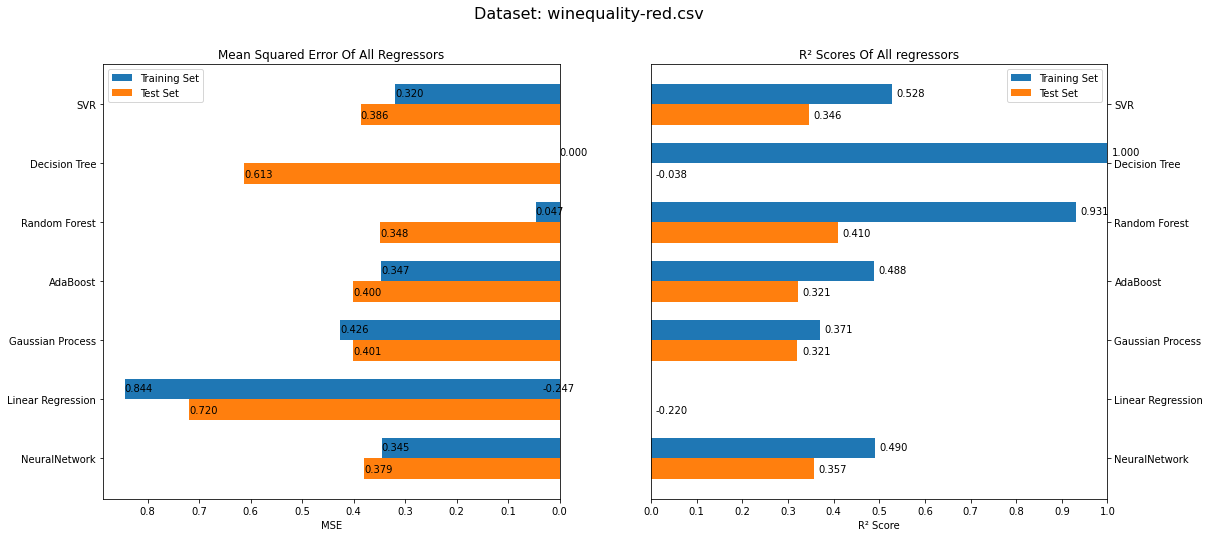

Dataset: winequality-white.csv
Replaced all '?' to np.nan
No question marks found
No given test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Training SVR ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training GaussianProcess ...
Training LinearRegression ...
Training NeuralNetwork ...


C:\Users\roshu\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


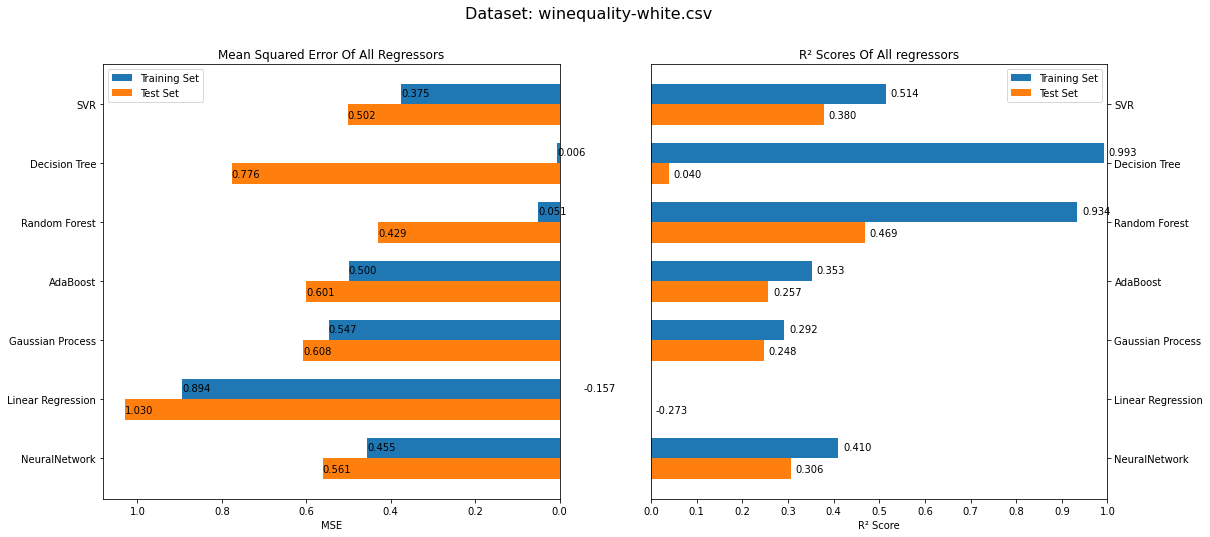

Dataset: communities.data
Replaced all '?' to np.nan
No question marks found
No given test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Training SVR ...
Training DecisionTree ...
Training RandomForest ...


KeyboardInterrupt: 

In [13]:
all_mse = dict()
all_r2 = dict()

# i = 0
# files=[files[i]]
# dfs = [dfs[i]]
# dfs_test = [dfs_test[i]]

for df, df_test, file in zip(dfs,dfs_test,files):
    print('Dataset: %s' % file)
#     df.info()
    df = replace_question_marks(df)
    df_test = replace_question_marks(df_test)
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    if type(df_test) == type(None):
        print('No given test set, dataset splitted')
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
    else:
        print('Loaded test set')
        X_train = X
        y_train = y
        X_test = df_test.iloc[:,:-1]
        y_test = df_test.iloc[:,-1]


    X_train, X_test = encode_labels(X_train,X_test)
    X_train, X_test = impute_value(X_train, X_test,'mean')
    X_train, X_test = normalize_data(X_train, X_test)
    X_train, X_test = dimension_reduction(X_train, X_test, n_components=15)
    
    all_regrs, regr_names = run_all_regrs(X_train, y_train, X_test, y_test)
    mse, r2 = plot_all(X_train, y_train, X_test, y_test, all_regrs, regr_names, file)
    
    for k,v in mse.items():
        if k not in all_mse:
            all_mse[k] = list()
        all_mse[k].append(v)
    for k,v in r2.items():
        if k not in all_r2:
            all_r2[k] = list()
        all_r2[k].append(v)    

In [14]:
for k,v in all_mse.items():
    print('%s-mse:'%k,["%.3f"%i for i in v])

SVR-mse: ['0.386', '0.502']
Decision Tree-mse: ['0.613', '0.776']
Random Forest-mse: ['0.348', '0.429']
AdaBoost-mse: ['0.400', '0.601']
Gaussian Process-mse: ['0.401', '0.608']
Linear Regression-mse: ['0.720', '1.030']
NeuralNetwork-mse: ['0.379', '0.561']


In [15]:
for k,v in all_r2.items():
    print('%s-r2:'%k,["%.3f"%i for i in v])

SVR-r2: ['0.346', '0.380']
Decision Tree-r2: ['-0.038', '0.040']
Random Forest-r2: ['0.410', '0.469']
AdaBoost-r2: ['0.321', '0.257']
Gaussian Process-r2: ['0.321', '0.248']
Linear Regression-r2: ['-0.220', '-0.273']
NeuralNetwork-r2: ['0.357', '0.306']


In [16]:
  for k,v in all_r2.items():
    print('%s avg r2: %.2f, avg mse: %.2f'%(k,np.mean(v),np.mean(all_mse[k])))

SVR avg r2: 0.36, avg mse: 0.44
Decision Tree avg r2: 0.00, avg mse: 0.69
Random Forest avg r2: 0.44, avg mse: 0.39
AdaBoost avg r2: 0.29, avg mse: 0.50
Gaussian Process avg r2: 0.28, avg mse: 0.50
Linear Regression avg r2: -0.25, avg mse: 0.87
NeuralNetwork avg r2: 0.33, avg mse: 0.47
